In [1]:
import nest
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Load trajectory data

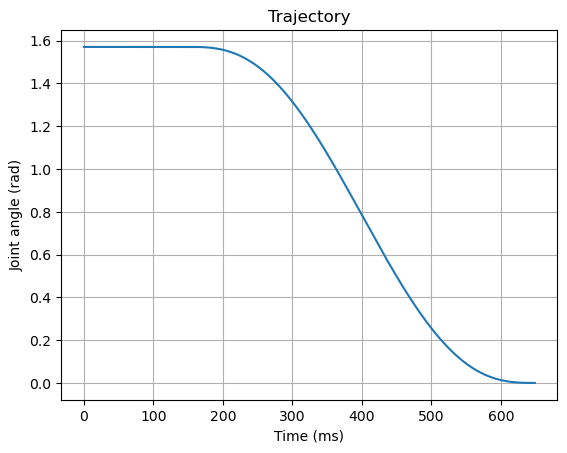

In [2]:
# Set the path to the dataset
dataset_path = (
	Path().resolve().parent
	/ "dataset_motor_training"
)

# Load the trajectory sample
trajectory_file_name = dataset_path / "trajectory1.txt"
trajectory_data = np.loadtxt(trajectory_file_name) 

# Define the task configuration
step_ms = 1.0              # Simulation timestep (ms)
n_timesteps_per_sequence = int(650.0 / step_ms)  # 650 ms at 1 ms resolution)
original_num_points = len(trajectory_data)
trajectory_original_resolution = 0.1  # ms
original_duration = original_num_points * trajectory_original_resolution
original_time = np.arange(original_num_points) * trajectory_original_resolution

# Resample the trajectory data
resampled_time = np.linspace(
	0, original_duration, n_timesteps_per_sequence, endpoint=False
)

# Resample the trajectory data to match the desired number of timesteps
trajectory_data_resampled = np.interp(
	resampled_time,
	original_time,
	trajectory_data,
)

# Plot the resampled trajectory
plt.plot(trajectory_data_resampled)
plt.title("Trajectory")
plt.xlabel("Time (ms)")
plt.ylabel("Joint angle (rad)")
plt.grid()

# Manual implementation of RBF encoding


Jul 15 14:40:04 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jul 15 14:40:04 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jul 15 14:40:04 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jul 15 14:40:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Jul 15 14:40:04 NodeManager::prepare_nodes [Info]: 
    Preparing 11 nodes for simulation.

Jul 15 14:40:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11
    Simulation time (ms): 650
    Number of OpenMP threads: 1
    Not using MPI

Jul 15 14:40:04 SimulationManager::run [Info]: 
    Simulation finished.


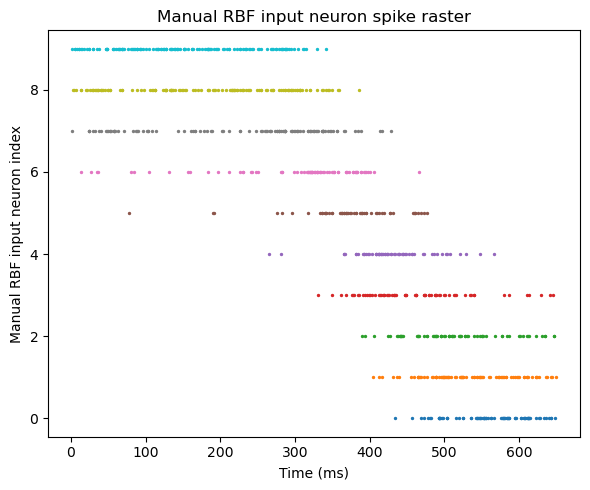

In [3]:
# ---- Parameters ----
num_centers = 10            # RBF/input neurons
width = 0.25                # RBF width
scale_rate = 500.0          # Max firing rate scaling (Hz)
rng_seed = 42

# Use the resampled trajectory
trajectory = trajectory_data_resampled
timesteps = len(trajectory)
t = np.arange(timesteps) * step_ms

# --- RBF encoding (matches original code logic) ---
centers = np.linspace(0.0, np.pi / 2.0, num_centers)
def gaussian_rbf(x, center, width):
    return np.exp(-((x - center) ** 2) / (2 * width**2))

rbf_inputs = np.zeros((n_timesteps_per_sequence, num_centers))
for i, center in enumerate(centers):
    rbf_inputs[:, i] = gaussian_rbf(trajectory_data_resampled, center, width)
rbf_rates = rbf_inputs * scale_rate

# --- NEST simulation: input layer only ---
nest.ResetKernel()
nest.set(resolution=step_ms, rng_seed=rng_seed)

gen_poisson_in = nest.Create("inhomogeneous_poisson_generator", num_centers)
rate_times = np.arange(n_timesteps_per_sequence) * step_ms + step_ms
params_gen_poisson_in = [
    {
        "rate_times": rate_times,
        "rate_values": rbf_rates[:, n_center],
    }
    for n_center in range(num_centers)
]
nest.SetStatus(gen_poisson_in, params_gen_poisson_in)

spike_recorder = nest.Create("spike_recorder")
nest.Connect(gen_poisson_in, spike_recorder, "all_to_all")

nest.Simulate(n_timesteps_per_sequence * step_ms)

# --- Plot manual RBF input spike raster for comparison ---
events_manual_rbf = spike_recorder.get("events")
spike_times_manual_rbf = np.array(events_manual_rbf["times"])
senders_manual_rbf = np.array(events_manual_rbf["senders"])
gids_manual_rbf = gen_poisson_in.tolist()

plt.figure(figsize=(6, 5))
for idx, gid in enumerate(gids_manual_rbf):
	neuron_spikes_manual_rbf = spike_times_manual_rbf[senders_manual_rbf == gid]
	plt.scatter(neuron_spikes_manual_rbf, np.ones_like(neuron_spikes_manual_rbf) * idx, s=2)
plt.xlabel('Time (ms)')
plt.ylabel('Manual RBF input neuron index')
plt.title('Manual RBF input neuron spike raster')
plt.tight_layout()
plt.show()


Jul 15 14:40:04 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jul 15 14:40:04 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jul 15 14:40:04 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jul 15 14:40:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Jul 15 14:40:04 Install [Info]: 
    loaded module motor_neuron_module

Jul 15 14:40:04 NodeManager::prepare_nodes [Info]: 
    Preparing 12 nodes for simulation.

Jul 15 14:40:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12
    Simulation time (ms): 650
    Number of OpenMP threads: 1
    Not using MPI

Jul 15 14:40:04 SimulationManager::run [Info]: 
    Simulation finished.


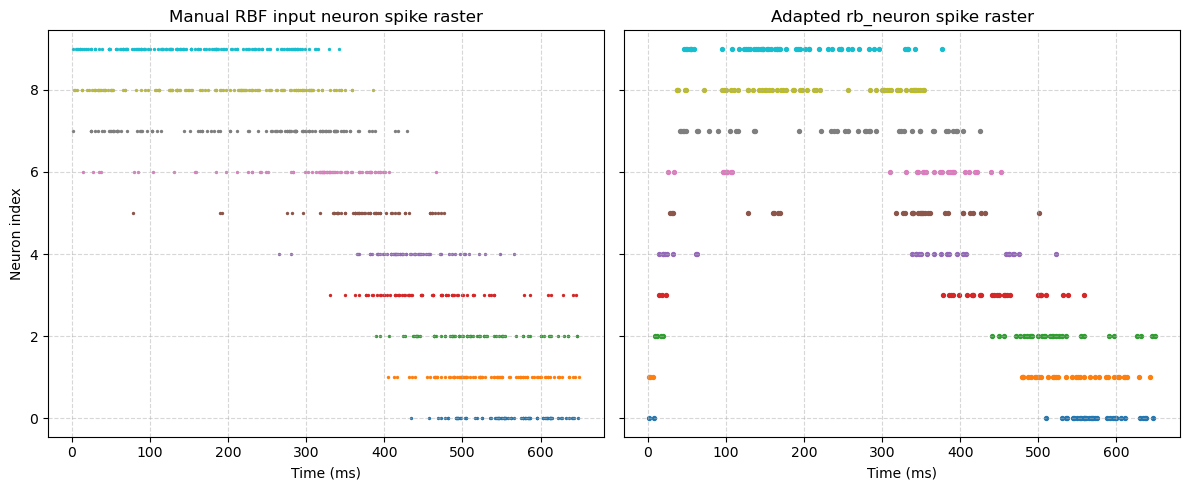

In [4]:
# ---- Adapted rb_neuron encoding and spike raster plot ----

# Reset NEST kernel and set simulation parameters
nest.ResetKernel()
nest.set(resolution=step_ms, rng_seed=rng_seed)

# Install custom motor neuron module
nest.Install("motor_neuron_module")

# --- Adaptation Parameters ---
# K: proportionality constant to map angles (rad) to rates (Hz)
K = 500.0
# RBF width (matches manual implementation)
width = 0.25

# Set parameters for rb_neuron model
rb_params = {
	# kp: gain so neuron's estimated in_rate matches true input rate
	"kp": 1000.0,
	# sdev: noise std, scaled from angle domain to rate domain
	"sdev": K * width,
	"base_rate": 0.0,
	"buffer_size": 50.0
}
nrns_rb = nest.Create("rb_neuron", num_centers)
nrns_rb.set(rb_params)

# Create input generator for Poisson spike trains
gen_poisson_in = nest.Create("inhomogeneous_poisson_generator")

# Connection parameters (all-to-all, no autapses)
params_conn_all_to_all = {"rule": "all_to_all", "allow_autapses": False}
params_syn_input_to_rb = {
	"synapse_model": "static_synapse",
	"delay": step_ms,
	"weight": 1.0,
}
nest.Connect(gen_poisson_in, nrns_rb, params_conn_all_to_all, params_syn_input_to_rb)

# Create spike recorder to record spikes from rb_neurons
spike_recorder = nest.Create("spike_recorder")
nest.Connect(nrns_rb, spike_recorder, "all_to_all")

# --- Set input rate proportional to angle ---
input_spk_rate = K * trajectory_data_resampled

# Generate time points for input rates
in_rate_times = np.arange(len(input_spk_rate)) * step_ms + step_ms

# Set Poisson generator parameters
params_gen_poisson_in = {
	"rate_times": in_rate_times,
	"rate_values": input_spk_rate,
}
nest.SetStatus(gen_poisson_in, params_gen_poisson_in)

# --- Set desired rates based on scaled angle centers ---
min_angle = np.min(trajectory_data_resampled)
max_angle = np.max(trajectory_data_resampled)
angle_centers = np.linspace(min_angle, max_angle, num_centers)
desired_rates = K * angle_centers
for i, nrn in enumerate(nrns_rb):
	nest.SetStatus(nrn, {"desired": desired_rates[i]})

# Simulate the network
nest.Simulate(n_timesteps_per_sequence * step_ms)

# --- Plotting ---
events_rb = spike_recorder.get("events")
spike_times_rb = np.array(events_rb["times"])
senders_rb = np.array(events_rb["senders"])
gids_rb = nrns_rb.tolist()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Manual RBF input neuron spike raster (for comparison)
axs[0].set_title('Manual RBF input neuron spike raster')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Neuron index')
axs[0].grid(True, linestyle='--', alpha=0.5)
for idx, gid in enumerate(gids_manual_rbf):
	neuron_spikes_manual_rbf = spike_times_manual_rbf[senders_manual_rbf == gid]
	axs[0].scatter(neuron_spikes_manual_rbf, np.ones_like(neuron_spikes_manual_rbf) * idx, s=2)

# Adapted rb_neuron spike raster
axs[1].set_title('Adapted rb_neuron spike raster')
axs[1].set_xlabel('Time (ms)')
axs[1].grid(True, linestyle='--', alpha=0.5)
for idx, gid in enumerate(gids_rb):
	neuron_spikes_rb = spike_times_rb[senders_rb == gid]
	axs[1].scatter(neuron_spikes_rb, np.full_like(neuron_spikes_rb, idx), s=8)

plt.tight_layout()
plt.show()
